In [ ]:
# enable huge pages
# echo always >/sys/kernel/mm/transparent_hugepage/enabled

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_theme(style='whitegrid')

In [3]:
def bench(source='pointers', n=2**20, q=2**20, cc='clang++'):
    !{cc} -std=c++17 -O3 -march=native -D N={n} -D Q={q} {source}.cc -o run
    res = !./run
    update, query, check = map(float, res)
    check = int(check)
    print(f'{source:>18} {cc:<7} {n:<7} {q:<7} {check:10} {update} {query}')
    return update, query

In [44]:
ns = list(int(1.17**k) for k in range(30, 110))

sources = [
    'pointers',
    'topdown-recursive',
    'topdown-iterative',
    # screw topdown-branchless -- it's too hard to implement and explain
    'fenwick',
    'fenwick-holes',
    'bottomup-twoends',
    'bottomup-general',
    'bottomup-branchless',
    'simd'
]

results = {}

In [45]:
for source in sources:
    results[source] = [bench(source, n=n, q=2**22) for n in ns]

          pointers clang++ 111     4194304   30137953 57.87 83.95
          pointers clang++ 129     4194304   12552218 60.84 88.88
          pointers clang++ 152     4194304   22270488 61.2 91.15
          pointers clang++ 177     4194304    3014878 62.87 95.31
          pointers clang++ 208     4194304   19584631 65.85 96.94
          pointers clang++ 243     4194304   18253269 67.89 100.36
          pointers clang++ 284     4194304   28214315 70.19 102.95
          pointers clang++ 333     4194304   26275784 72.93 108.22
          pointers clang++ 389     4194304     982020 76.5 110.63
          pointers clang++ 456     4194304    2349222 80.87 115.57
          pointers clang++ 533     4194304   25956268 83.94 117.74
          pointers clang++ 624     4194304   22596458 89.43 120.97
          pointers clang++ 730     4194304    4305393 94.08 126.91
          pointers clang++ 855     4194304   22974297 97.93 128.96
          pointers clang++ 1000    4194304   22416047 103.32 135.23
 

In [170]:
simd64 = [bench('simd', n=n, q=2**22) for n in ns]

              simd clang++ 111     4194304   30137953 12.78 1.31
              simd clang++ 129     4194304   12552218 12.76 1.33
              simd clang++ 152     4194304   22270488 12.77 1.33
              simd clang++ 177     4194304    3014878 12.77 1.35
              simd clang++ 208     4194304   19584631 12.77 1.32
              simd clang++ 243     4194304   18253269 12.88 1.35
              simd clang++ 284     4194304   28214315 12.77 1.32
              simd clang++ 333     4194304   26275784 12.76 1.32
              simd clang++ 389     4194304     982020 12.93 1.34
              simd clang++ 456     4194304    2349222 12.78 1.31
              simd clang++ 533     4194304   25956268 12.76 1.31
              simd clang++ 624     4194304   22596458 12.81 1.32
              simd clang++ 730     4194304    4305393 12.79 1.31
              simd clang++ 855     4194304   22974297 12.78 1.32
              simd clang++ 1000    4194304   22416047 12.79 1.32
              simd clang+

In [52]:
results['simd8'] = simd8
results['simd32'] = simd32
results['simd64'] = simd64

In [171]:

results['simd64'] = simd64

In [173]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [294]:
def plot(filename, title, plots, relative=None, ylim=None):
    fig, (top, bot) = plt.subplots(2, sharex=True, sharey=(relative is None))

    top.label_outer()

    if title:
        fig.suptitle(title, y=0.95)

    plt.xscale('log', basex=2)
    plt.xlabel('Array size')

    top.set_ylabel('Update')
    bot.set_ylabel('Prefix sum')

    for source, color, label in plots:
        x, y = map(list, zip(*results[source]))

        lim = 74

        x = x[:lim]
        y = y[:lim]

        if relative:
            px, py = map(list, zip(*results[relative][:lim]))
            x = [b / a for a, b in zip(x, px)]
            y = [b / a for a, b in zip(y, py)]

        top.plot(ns[:lim], x, color=color, label=label)
        bot.plot(ns[:lim], y, color=color, label=label)

    plt.ylim(bottom=0, top=ylim)
    plt.xlim(1000, 10**7)

    for x in [2**13, 2**17, 2**20]:
        for graph in [top, bot]:
            graph.axvline(x=x, color='black', lw=1, linestyle='--')

    if len(plots) > 1:
        top.legend(loc='upper left')
    plt.margins(0)

    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    fig.savefig(filename)

    plt.show()

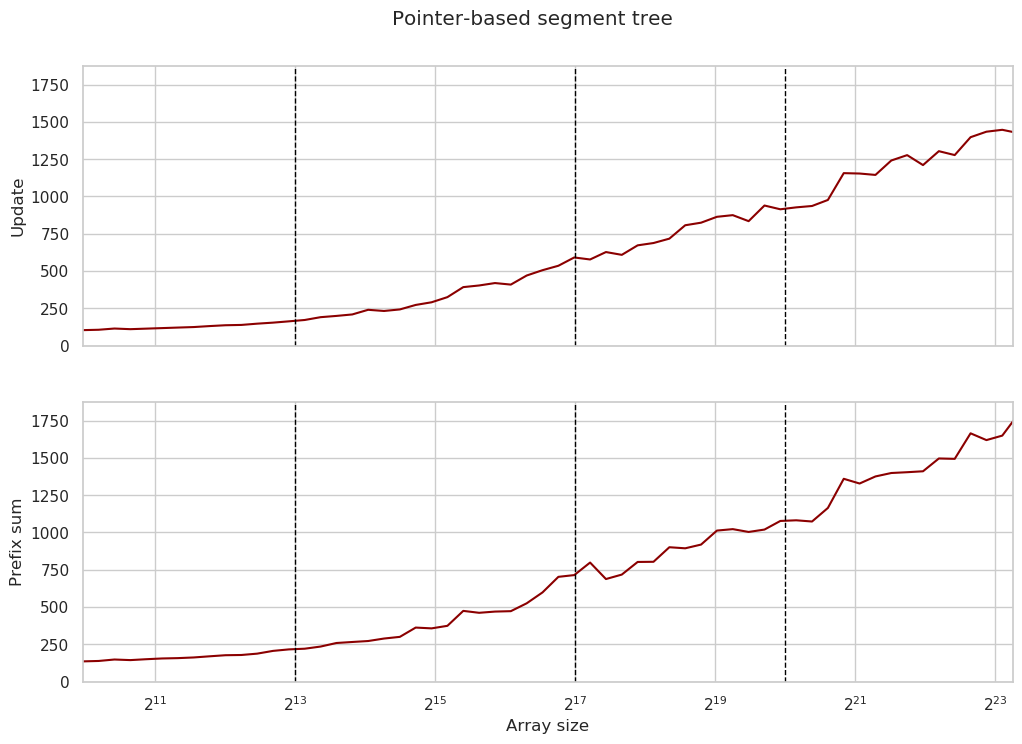

In [296]:
plot('segtree-pointers.svg', "Pointer-based segment tree", [
    ('pointers', 'darkred', 'Pointer-based segment tree'),
])

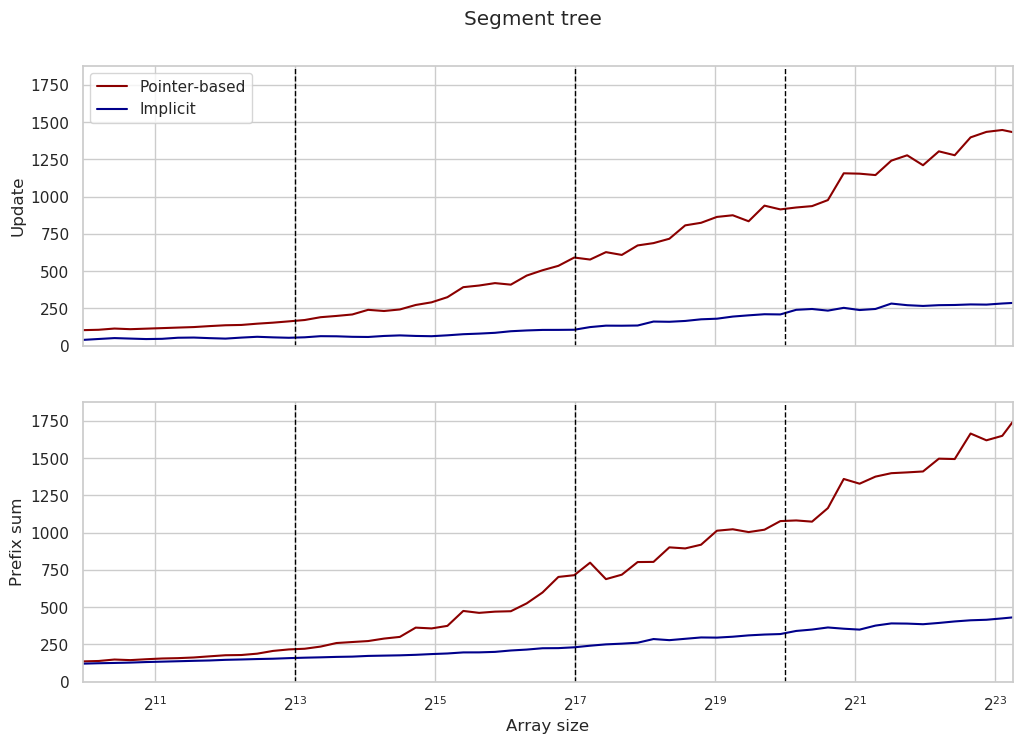

In [297]:
plot('segtree-topdown.svg', 'Segment tree', [
    ('pointers', 'darkred', 'Pointer-based'),
    ('topdown-recursive', 'darkblue', 'Implicit'),
])

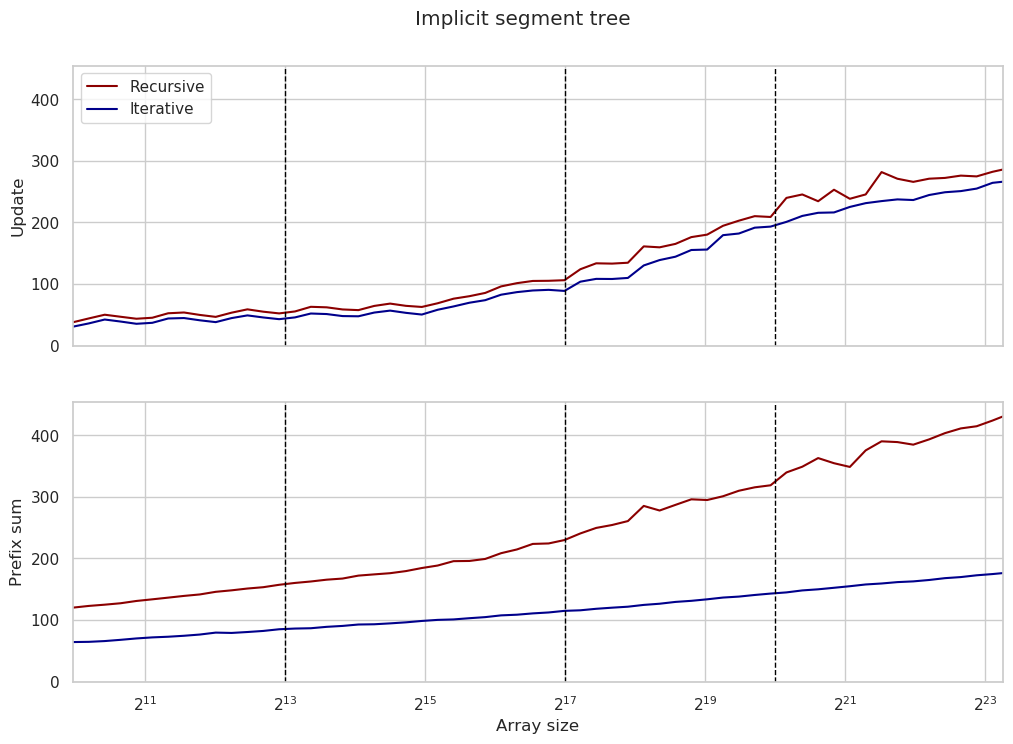

In [298]:
plot('segtree-iterative.svg', 'Implicit segment tree', [
    ('topdown-recursive', 'darkred', 'Recursive'),
    ('topdown-iterative', 'darkblue', 'Iterative'),
])

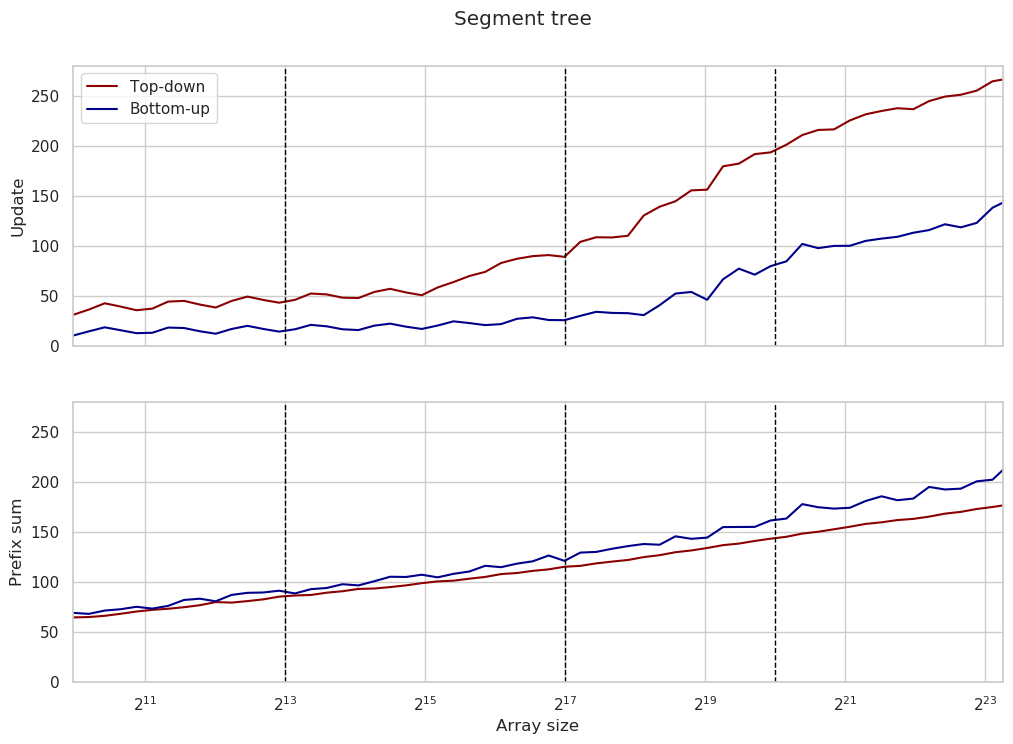

In [301]:
plot('segtree-bottomup.svg', 'Segment tree', [
    ('topdown-iterative', 'darkred', 'Top-down'),
    ('bottomup-twoends', 'darkblue', 'Bottom-up'),
])

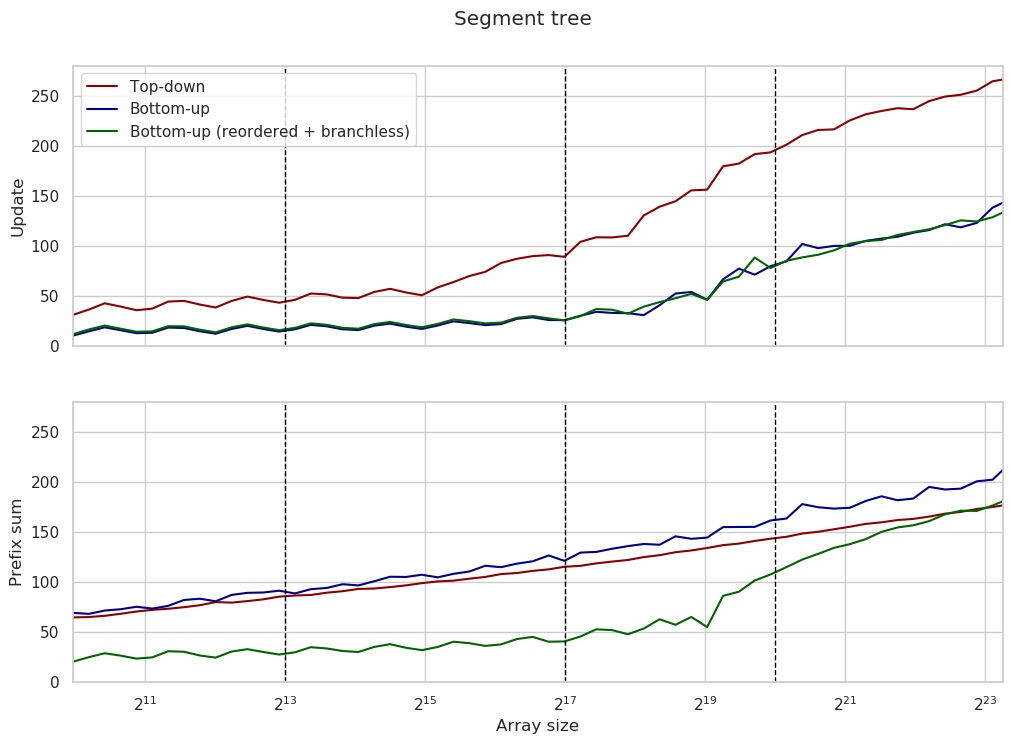

In [302]:
plot('segtree-branchless.svg', 'Segment tree', [
    ('topdown-iterative', 'darkred', 'Top-down'),
    ('bottomup-twoends', 'darkblue', 'Bottom-up'),
    ('bottomup-branchless', 'darkgreen', 'Bottom-up (reordered + branchless)'),
])

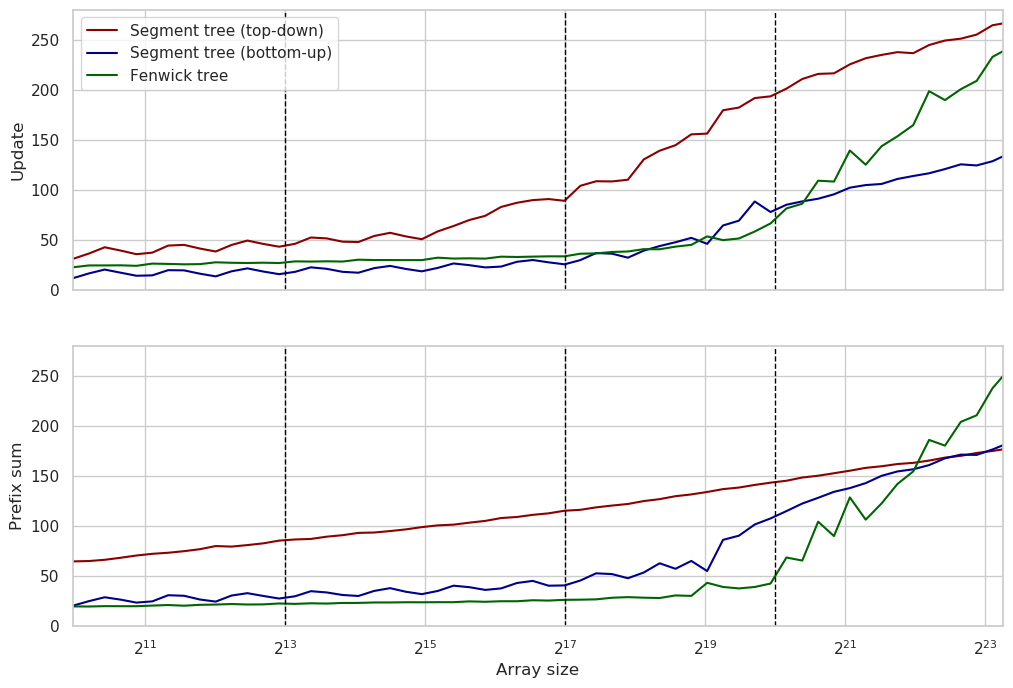

In [304]:
plot('segtree-fenwick.svg', None, [
    ('topdown-iterative', 'darkred', 'Segment tree (top-down)'),
    ('bottomup-branchless', 'darkblue', 'Segment tree (bottom-up)'),
    ('fenwick', 'darkgreen', 'Fenwick tree'),
])

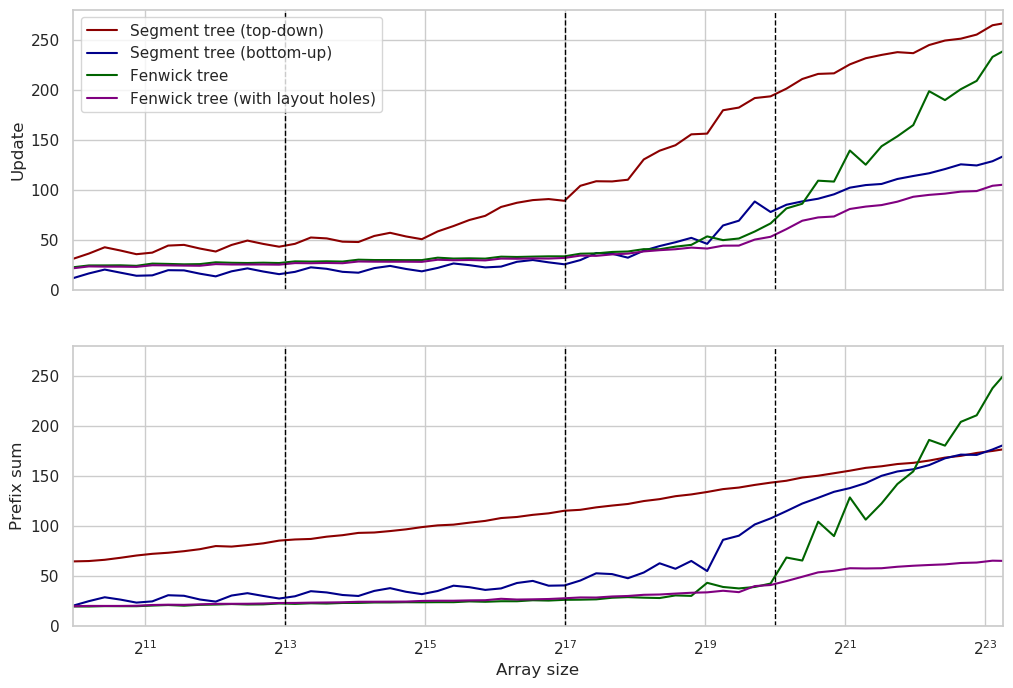

In [305]:
plot('segtree-fenwick-holes.svg', None, [
    ('topdown-iterative', 'darkred', 'Segment tree (top-down)'),
    ('bottomup-branchless', 'darkblue', 'Segment tree (bottom-up)'),
    ('fenwick', 'darkgreen', 'Fenwick tree'),
    ('fenwick-holes', 'purple', 'Fenwick tree (with layout holes)'),
])

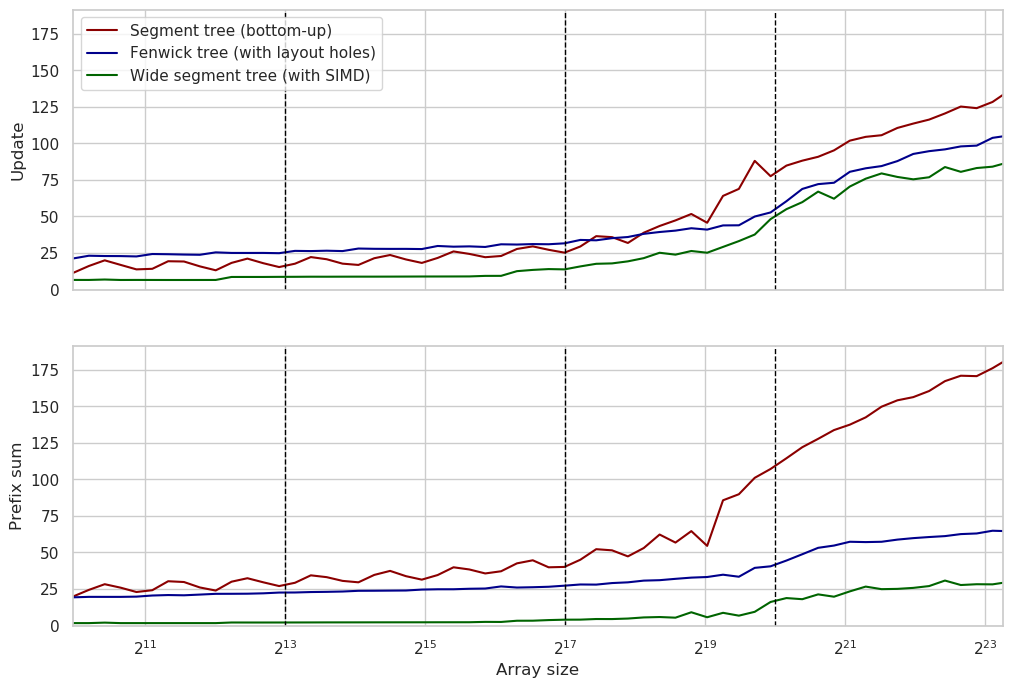

In [306]:
plot('segtree-simd.svg', None, [
    ('bottomup-branchless', 'darkred', 'Segment tree (bottom-up)'),
    ('fenwick-holes', 'darkblue', 'Fenwick tree (with layout holes)'),
    ('simd', 'darkgreen', 'Wide segment tree (with SIMD)'),
])

In [307]:
for (x, y), (a, b) in zip(results['pointers'], results['simd']):
    print(x / a, y / b)

11.236893203883493 59.11971830985916
11.836575875486382 67.8473282442748
11.814671814671815 65.57553956834533
12.231517509727627 66.65034965034965
12.811284046692606 68.7517730496454
13.156976744186046 76.61068702290076
10.61875945537065 61.646706586826355
11.083586626139818 65.19277108433735
11.661585365853659 66.24550898203593
12.271623672230653 68.79166666666667
12.69894099848714 70.50299401197604
13.611872146118722 72.87349397590361
14.341463414634147 75.9940119760479
14.928353658536587 77.22155688622755
15.702127659574467 80.97604790419162
16.120243531202433 82.65868263473054
16.635568513119534 73.895
16.76946564885496 86.12574850299403
17.237082066869302 89.67664670658682
17.83689024390244 92.69461077844312
18.4434250764526 94.05389221556887
18.966360856269112 96.75449101796409
19.934351145038168 101.36526946107784
20.760670731707318 105.7245508982036
16.05807200929152 85.20574162679426
17.02552204176334 89.98076923076923
17.82366589327146 98.84615384615384
18.683544303797472 103

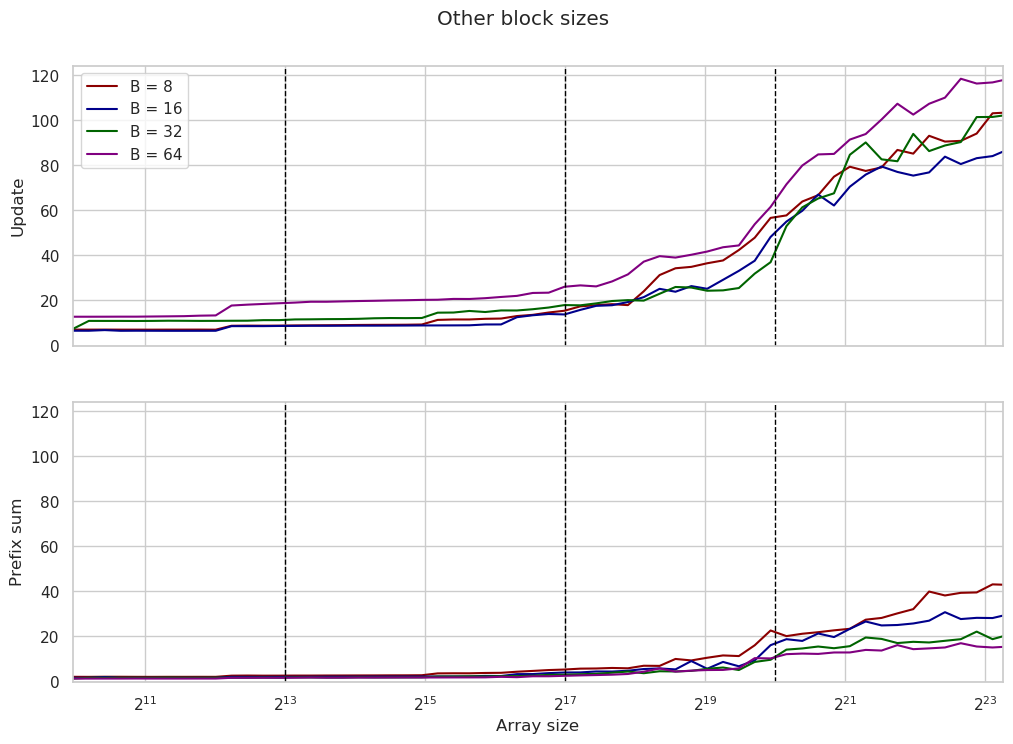

In [308]:
plot('segtree-simd-others.svg', 'Other block sizes', [
    ('simd8', 'darkred', 'B = 8'),
    ('simd', 'darkblue', 'B = 16'),
    ('simd32', 'darkgreen', 'B = 32'),
    ('simd64', 'purple', 'B = 64'),
])

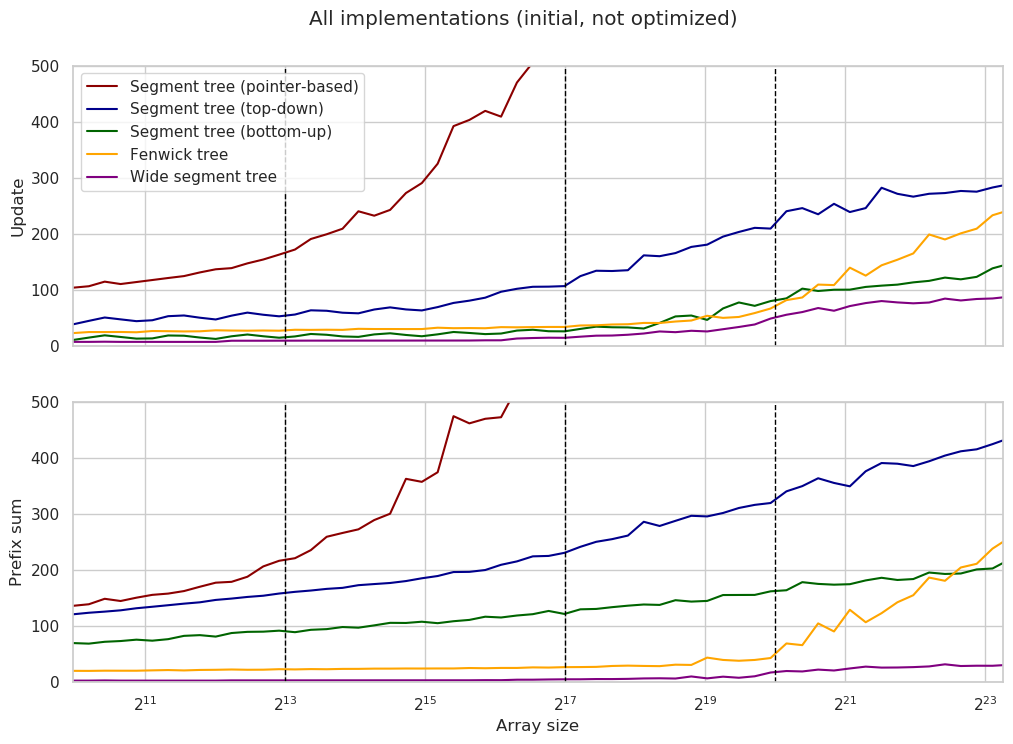

In [310]:
plot('segtree-popular.svg', "All implementations (initial, not optimized)", [
    ('pointers', 'darkred', 'Segment tree (pointer-based)'),
    ('topdown-recursive', 'darkblue', 'Segment tree (top-down)'),
    ('bottomup-twoends', 'darkgreen', 'Segment tree (bottom-up)'),
    ('fenwick', 'orange', 'Fenwick tree'),
    ('simd', 'purple', 'Wide segment tree'),
], ylim=500)

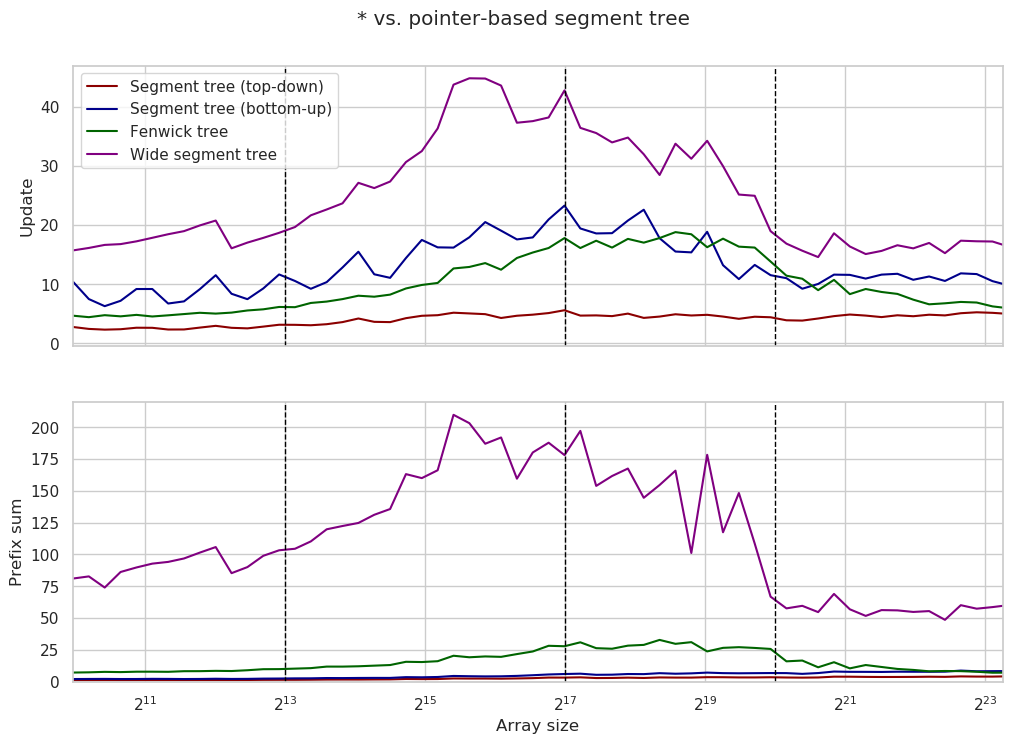

In [311]:
plot('segtree-popular-relative.svg', '* vs. pointer-based segment tree', [
    #('pointers', 'darkred', 'Segment tree (pointer-based)'),
    ('topdown-recursive', 'darkred', 'Segment tree (top-down)'),
    ('bottomup-twoends', 'darkblue', 'Segment tree (bottom-up)'),
    ('fenwick', 'darkgreen', 'Fenwick tree'),
    ('simd', 'purple', 'Wide segment tree'),
], relative='pointers')